In [3]:
import os
from random import random


def count_files_and_check_correspondence(dir_path, results=None):
    if results is None:
        results = {}

    # Check if current path is a directory, if not, just return
    if not os.path.isdir(dir_path):
        return results

    # Initialize counts and sets for the current directory
    jpg_count = 0
    png_count = 0
    correspondence_check = True
    jpg_files = set()
    png_files = set()

    # Explore each item in the directory
    for entry in os.listdir(dir_path):
        full_path = os.path.join(dir_path, entry)
        if os.path.isdir(full_path):
            # Recursively call the function for subdirectories
            count_files_and_check_correspondence(full_path, results)
        elif entry.endswith('.jpg'):
            jpg_count += 1
            jpg_files.add(entry)
        elif entry.endswith('.png'):
            png_count += 1
            png_files.add(entry)

    # Update results for the current directory
    if dir_path not in results:
        results[dir_path] = {
            'jpg_count': 0,
            'png_count': 0,
            'all_jpg_have_corresponding_png': True
        }

    # Increment the counts and check correspondence
    results[dir_path]['jpg_count'] += jpg_count
    results[dir_path]['png_count'] += png_count

    for jpg_file in jpg_files:
        expected_png = jpg_file.replace('.jpg', '.png')
        if expected_png not in png_files:
            correspondence_check = False

    results[dir_path]['all_jpg_have_corresponding_png'] &= correspondence_check

    return results


base_path = './SAM_Finetuning/Crack500/TrueSet'
result = count_files_and_check_correspondence(base_path)

Largest bounding box: (17, 0, 2537, 1439)


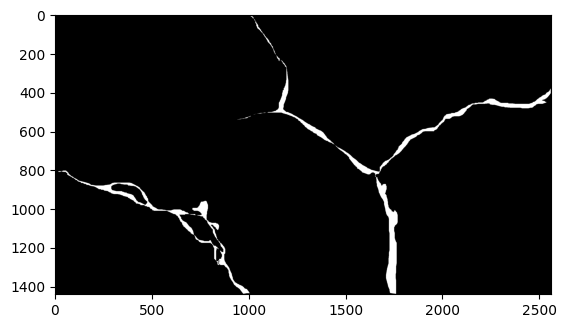

In [4]:
import glob
import cv2
import matplotlib.pyplot as plt
img_paths = glob.glob('./SAM_Finetuning/Crack500/TrueSet/True_Images/*.jpg')
mask_paths = glob.glob('./SAM_Finetuning/Crack500/TrueSet/True_Masks/*.png')


# Assuming mask_paths is a list containing paths to mask images
mask = cv2.imread(mask_paths[1])
mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# Find contours in the binary mask
contours, _ = cv2.findContours(mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize variables to store the bounding box coordinates
x_min, y_min = float('inf'), float('inf')
x_max, y_max = float('-inf'), float('-inf')

# Loop through each contour to find the extreme points
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    x_min = min(x_min, x)
    y_min = min(y_min, y)
    x_max = max(x_max, x + w)
    y_max = max(y_max, y + h)

# Return the largest bounding box
largest_bbox = (x_min, y_min, x_max - x_min, y_max - y_min)
print("Largest bounding box:", largest_bbox)

plt.imshow(mask_gray, cmap='gray')
plt.show()

In [5]:
import numpy as np
# Function to find the largest bounding box for a mask
def find_largest_bbox(mask):
    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to store the bounding box coordinates
    x_min, y_min = float('inf'), float('inf')
    x_max, y_max = float('-inf'), float('-inf')

    # Loop through each contour to find the extreme points
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)

    largest_bbox = np.array([x_min, y_min, x_max, y_max])
    return largest_bbox

In [6]:
from pathlib import Path
bbox_coords = {}

mask_path = Path('./SAM_Finetuning/Crack500/TrueSet/True_Masks/')
for f in mask_path.iterdir():
    if f.suffix == '.png':  # Ensure we're only processing PNG files
        k = f.stem
        mask = cv2.imread(f.as_posix())
        largest_bbox = find_largest_bbox(mask)
        bbox_coords[k] = largest_bbox
        
ground_truth_masks = {}
for k in bbox_coords.keys():
    gt_grayscale = cv2.imread(f"./SAM_Finetuning/Crack500/TrueSet/True_Masks/{k}.png", cv2.IMREAD_GRAYSCALE)
    ground_truth_masks[k] = (gt_grayscale == 255)

In [7]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

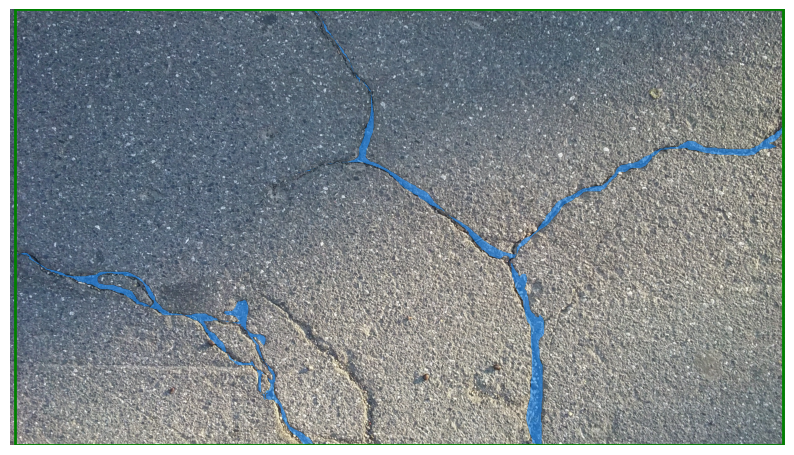

In [8]:
# Visualize an example
name = list(bbox_coords.keys())[1]
image = cv2.imread(f'./SAM_Finetuning/Crack500/TrueSet/True_Images/{name}.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
show_box(bbox_coords[name], plt.gca())
show_mask(ground_truth_masks[name], plt.gca())
plt.axis('off')
plt.show()

In [9]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

In [10]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
for k in bbox_coords.keys():
  image = cv2.imread(f'./SAM_Finetuning/Crack500/TrueSet/True_Images/{name}.jpg')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  transformed_data[k]['image'] = input_image
  transformed_data[k]['input_size'] = input_size
  transformed_data[k]['original_image_size'] = original_image_size

In [32]:
import random 

keys = list(bbox_coords.keys())

test_key = random.choice(keys)

print(transformed_data[test_key]['input_size'])
print(transformed_data[test_key]['original_image_size'])

(576, 1024)
(1440, 2560)


In [11]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        # Flatten the predictions and targets
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)

        # Calculate intersection and union
        intersection = (pred * target).sum()
        dice_coeff = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        # Dice loss
        loss = 1 - dice_coeff
        return loss

In [27]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

bce_loss= torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss()
# dice_loss = DiceLoss()
# mse_dice_loss = lambda pred, target: mse_loss(pred, target) + dice_loss(pred, target)
loss_fn = mse_loss

keys = list(bbox_coords.keys())

In [28]:

from statistics import mean
from torch.nn.functional import threshold, normalize
import random

num_epochs = 100
losses = []

for epoch in range(num_epochs):
    epoch_losses = []
    
    # keys에서 랜덤하게 50개 선택
    sampled_keys = random.sample(keys, 50)
    for k in sampled_keys:
        input_image = transformed_data[k]['image'].to(device)
        input_size = transformed_data[k]['input_size']
        original_image_size = transformed_data[k]['original_image_size']
        
        with torch.no_grad():
            # encoder를 훈련시키는 건 어려움이 있
            image_embedding = sam_model.image_encoder(input_image)
            
            prompt_box = bbox_coords[k]
            box = transform.apply_boxes(prompt_box, original_image_size)
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            box_torch = box_torch[None, :]
            
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points = None,
                boxes = box_torch,
                masks = None,
            )
        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings = image_embedding,
            image_pe = sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings = sparse_embeddings,
            dense_prompt_embeddings = dense_embeddings,
            multimask_output = False,
        )
        
        upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))
        
        gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1,1,ground_truth_masks[k].shape[0],ground_truth_masks[k].shape[1]))).to(device)
        gt_binary_mask = torch.as_tensor(gt_mask_resized>0, dtype=torch.float32)
        
        loss = loss_fn(binary_mask, gt_binary_mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    losses.append(epoch_losses)
    
    print(f"Epoch {epoch} loss: {np.mean(epoch_losses)}")

Epoch 0 loss: 0.9706937456130982
Epoch 1 loss: 0.9742592024803162
Epoch 2 loss: 0.9687536787986756
Epoch 3 loss: 0.9710736155509949
Epoch 4 loss: 0.9699679446220398
Epoch 5 loss: 0.971902403831482
Epoch 6 loss: 0.9675896096229554
Epoch 7 loss: 0.9696764624118805
Epoch 8 loss: 0.9722744286060333
Epoch 9 loss: 0.9733784806728363
Epoch 10 loss: 0.9681091940402985
Epoch 11 loss: 0.9709875273704529
Epoch 12 loss: 0.9719213509559631
Epoch 13 loss: 0.9685685324668885
Epoch 14 loss: 0.9711136221885681
Epoch 15 loss: 0.969806079864502
Epoch 16 loss: 0.9767155182361603
Epoch 17 loss: 0.9681300950050354
Epoch 18 loss: 0.9675216293334961
Epoch 19 loss: 0.9725018906593322
Epoch 20 loss: 0.9651371216773987
Epoch 21 loss: 0.9703193306922913
Epoch 22 loss: 0.9723914909362793
Epoch 23 loss: 0.970883880853653
Epoch 24 loss: 0.9701668441295623
Epoch 25 loss: 0.967833286523819
Epoch 26 loss: 0.9711352908611297
Epoch 27 loss: 0.9698875296115875
Epoch 28 loss: 0.9689594769477844
Epoch 29 loss: 0.97166573166

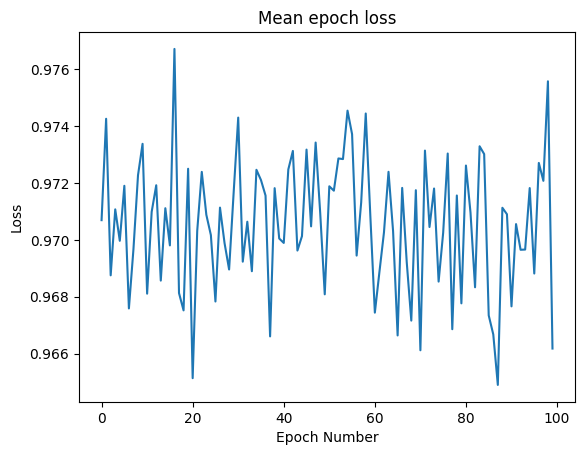

In [29]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

# 기존 모델과 Fine-tuning 비교

In [30]:
sam_model_original = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_original.to(device);

In [31]:
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_original)

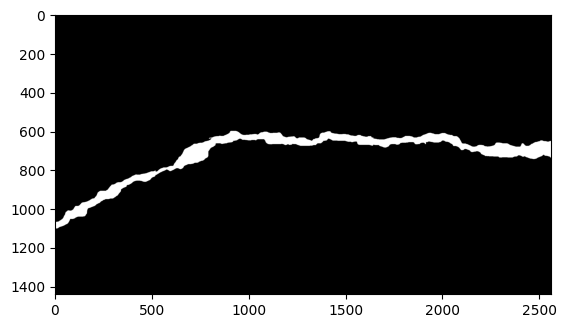

In [45]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
k = keys[2]
image = cv2.imread(f'./SAM_Finetuning/Crack500/TrueSet/True_Images/{k}.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask_gt = cv2.imread(f'./SAM_Finetuning/Crack500/TrueSet/True_Masks/{k}.png')


plt.imshow(mask_gt, cmap='gray')
predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

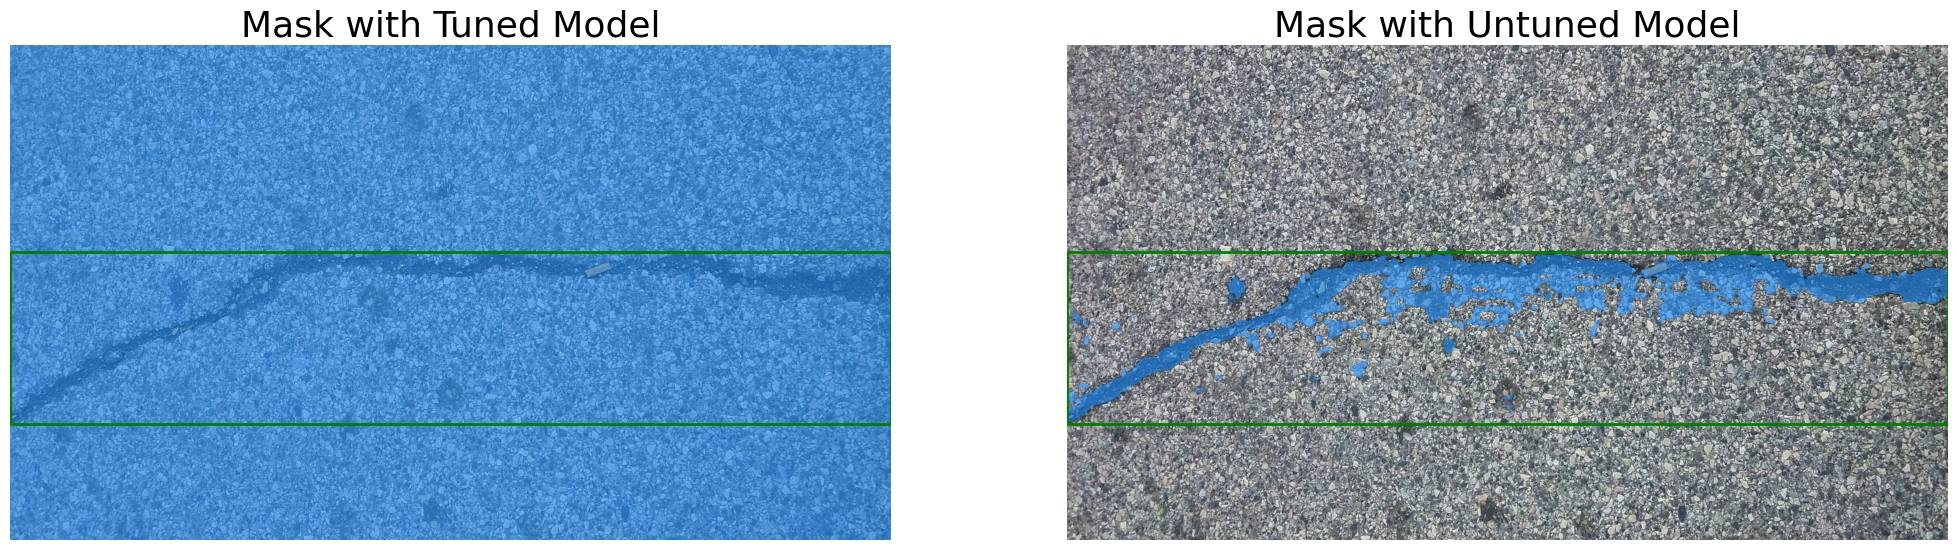

In [46]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()